In [1]:
from torchvision.models.segmentation import (
    lraspp_mobilenet_v3_large,
    deeplabv3_resnet50,
    deeplabv3_mobilenet_v3_large,
)
import argparse
from loguru import logger
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import torchmetrics
from torchmetrics.classification import BinaryJaccardIndex

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import fnmatch
import numpy as np
import torchvision.transforms as transforms
from torchvision.models import mobilenetv3, ResNet50_Weights
import random
import torch.nn.functional as F
from loguru import logger
from tqdm import tqdm
from datetime import datetime
import math
from models import Model4Band

/home/rdaroya_umass_edu/miniconda3/envs/lsa/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
with_transforms = False
# ckpt_path = "ckpts/deeplab_mobilenet/20240120-235106_e45.pth"
# ckpt_path = "ckpts/deeplab_resnet/20240120-235337_e36.pth"
# ckpt_path = "ckpts/lraspp/20240120-235412_e38.pth"
# NOTE: ckpts after this, need to do standardization on input image

with_transforms = True
# ckpt_path = "ckpts/deeplab_mobilenet/20240121-224805_e72.pth"
ckpt_path = "ckpts/deeplab_resnet/20240121-225412_e04.pth"
# ckpt_path = "ckpts/lraspp/20240121-230220_e46.pth"

model_type = ckpt_path.split("/")[-2]
model_type

'deeplab_resnet'

In [20]:
class SatelliteDataRGB(Dataset):
    """
    This file is directly modified from https://pytorch.org/docs/stable/torchvision/datasets.html
    """
    def __init__(self, root, crop_size, split='train', transforms=None, is_rgb=False):
        self.split = split
        self.root = os.path.expanduser(root)
        self.transforms = transforms
        self.is_rgb = is_rgb

        # R\read the data file
        if split=="train":
            self.data_path = os.path.join(root, 'train')
        elif split=="val":
            self.data_path = os.path.join(root, 'val')
        elif split=="test":
            self.data_path = os.path.join(root, 'test')
        else:
            raise NotImplementedError

        # calculate data length
        self.fps = fnmatch.filter(os.listdir(self.data_path), '*.npy')
        self.data_len = len(self.fps)
        self.crop_size = crop_size

    def __getitem__(self, index):
        # fp = os.path.join(self.data_path, f"{index:06d}.npy")
        fp = os.path.join(self.data_path, self.fps[index])
        with open(fp, "rb") as f:
            npzfile = np.load(f)
            input_data = npzfile["input"]  # (4, 256, 256) (C,H,W)
            output_data = npzfile["output"]  # (1, 256, 256) (C,H,W)
        
        label = torch.from_numpy(output_data)
        if self.is_rgb:
            image = torch.from_numpy(input_data[:3,:,:])
            if self.transforms is not None:
                image = image[:, :self.crop_size, :self.crop_size]
                label = label[:, :self.crop_size, :self.crop_size]
                image = self.transforms(image)
        else:
            image = torch.from_numpy(input_data[:,:,:])
            # if self.transforms is not None:
            image = image[:, :self.crop_size, :self.crop_size]
            label = label[:, :self.crop_size, :self.crop_size]
            image = image/255.   # normalize 0 to 1
            if self.transforms is not None:
                image = self.transforms(image)
            # img_mean = torch.reshape(torch.mean(image, dim=(1,2)), (4,1,1))
            # img_var = torch.reshape(torch.var(image, dim=(1,2)), (4,1,1))
            # image = (image - img_mean)/(img_var**0.5)     # standardize
        return (
            image.type(torch.FloatTensor),
            label.type(torch.FloatTensor),
        )

    def __len__(self):
        return self.data_len

In [21]:

is_rgb = False
model = Model4Band(model_type=model_type).cuda()
crop_size = model.crop_size
if with_transforms:
    trans = transforms.Compose([
        transforms.Normalize((0.485, 0.456, 0.406, 0.485), (0.229, 0.224, 0.225, 0.229)),
    ])
else:
    trans = None


test_dataset = SatelliteDataRGB(root="segtrain_data", split="test", crop_size=crop_size, transforms=trans, is_rgb=is_rgb)

In [22]:
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

In [23]:
for x,y in test_dataset:
    if torch.sum(y)>0:
        print(x.shape, y.shape, torch.sum(y))
        break

torch.Size([4, 224, 224]) torch.Size([1, 224, 224]) tensor(30073.)


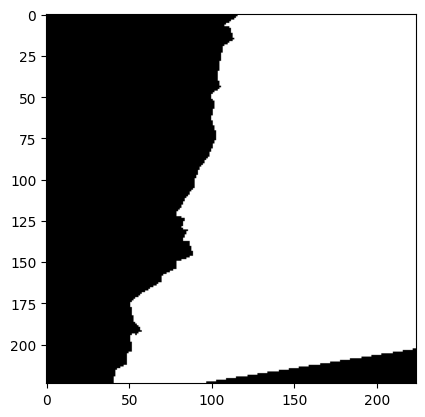

In [24]:
from matplotlib import pyplot as plt 
plt.imshow(y.squeeze(), cmap="gray")

In [25]:
# torch.max(pred), torch.min(pred)

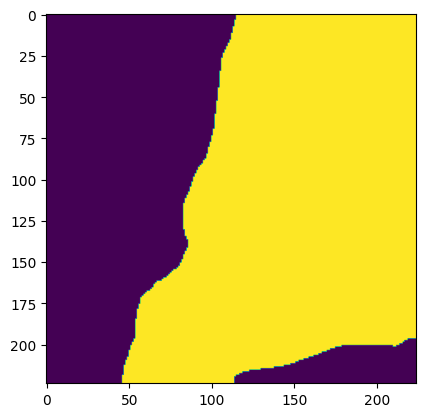

In [26]:
model.eval()
pred = model(x.unsqueeze(0).cuda())["out"]
pred_np = pred.detach().cpu().numpy().squeeze()
pred_np = pred_np>0.5
plt.imshow(pred_np)